In [1]:
import pandas as pd
import numpy as np
from prophet import Prophet
from datetime import datetime
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina' 


In [84]:
def height_to_unixepoch(height: int) -> int:
    return height * 30 + 1598306400

def height_to_timestamp(height: int) -> datetime:
    return datetime.fromtimestamp(height_to_unixepoch(height))

def unixepoch_to_height(timestamp):
    return (timestamp - 1598306400)/30

def datetime_to_height(year:int, month:int, day:int) -> float:
    dd = int(datetime(year, month, day).strftime('%s'))
    return int((dd - 1598306400)/30)

def interpolate_predictions(df, fcst, feature, yhat='yhat'):
    '''
    Takes the daily predictions from Prophet and interpolates it at the epoch level.

    Parameters
    ----------
    df (pd.DataFrame): original dataframe, sampled at epoch frequency
    fcst (pd.DataFrame): output dataframe from Prophet (must have columns ds, yhat, yhat_lower, yhat_upper)
    yhat (string): whether to use Prophet's median ('yhat'), optimistic ('yhat_upper') or pessimistic ('yhat_lower') prediction

    Returns
    -------
    df_new (pd.DataFrame): interpolates daily Prophet prediction into an epoch-wise prediction. When feature 
                           is 'raw_bytes_network_power',  this function will also calculate the network time 
                           in epoch units. 
    '''

    df_p = fcst[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].iloc[-300:]

    if feature == 'raw_bytes_network_power':

        assert 'raw_bytes_network_power' in df.columns, "raw_bytes_network_power not in epoch-level dataframe"

        # Populate a new epoch-wise dataframe for the forward predictions
        df_new = pd.DataFrame()
        df_new['height'] = np.arange(df.height.max(), 300*2880+df.height.max())
        df_new['datetime'] = df_new['height'].apply(height_to_timestamp)

        # Impute the daily prediction at 12 midnight of each day
        midnight_condition = (df_new['datetime'].dt.hour == 0) & (df_new['datetime'].dt.minute == 0) & (df_new['datetime'].dt.second == 0)
        df_new['raw_bytes_network_power'] = np.nan

        midnight_idx = np.argwhere(midnight_condition.values>0).reshape(1,-1)[0]
        for i,idx in enumerate(midnight_idx):
            df_new.loc[idx, 'raw_bytes_network_power'] = df_p.iloc[-300:][yh].values[i]

        # Patch the first row of the extrapolated dataframe to the last row of the actual chain data, to facilitate interpolation
        # There will therefore be 301 interpolated points in the epoch-wise extrapolated dataframe
        df_new.loc[0, 'raw_bytes_network_power'] = df['raw_bytes_network_power'].iloc[-1]
        df_new['raw_bytes_network_power'] = df_new['raw_bytes_network_power'].interpolate(method='linear', limit_direction='forward')

        dynamic_baseline = lambda epoch: df.new_baseline_power.iloc[0] * np.exp(np.log(2)/525600/2*epoch)
        g = np.log(2)/31536000*30 # the growth rate in epoch units
        b0 = 2.888888 * 2**60 / 2**50

        # Don't forget to drop the duplicate row in df_new before concat
        df_out = pd.concat([df[['height', 'datetime', 'raw_bytes_network_power']], 
                            df_new[['height', 'datetime', 'raw_bytes_network_power']].iloc[1:]]) 
        df_out = df_out.reset_index(drop=True)
        df_out['baseline_power'] = dynamic_baseline(np.arange(len(df_out)))
        df_out['cumsum_capped_rb_power'] = df_out[['raw_bytes_network_power', 'baseline_power']].min(axis=1).cumsum()
        df_out['est_network_height'] = 15410 + 1.055*np.log(df_out['cumsum_capped_rb_power']*g/b0 + 1)/g   

    else: 

        assert feature in df.columns, "%s not in epoch-level dataframe" % feature

        # Populate a new epoch-wise dataframe for the forward predictions
        df_new = pd.DataFrame()
        df_new['height'] = np.arange(df.height.max(), 300*2880+df.height.max())
        df_new['datetime'] = df_new['height'].apply(height_to_timestamp)

        # Impute the daily prediction at 12 midnight of each day
        midnight_condition = (df_new['datetime'].dt.hour == 0) & (df_new['datetime'].dt.minute == 0) & (df_new['datetime'].dt.second == 0)
        df_new[feature] = np.nan

        midnight_idx = np.argwhere(midnight_condition.values>0).reshape(1,-1)[0]
        for i,idx in enumerate(midnight_idx):
            df_new.loc[idx, feature] = df_p.iloc[-300:]['yhat'].values[i]

        # Patch the first row of the extrapolated dataframe to the last row of the actual chain data, to facilitate interpolation
        # There will therefore be 301 interpolated points in the epoch-wise extrapolated dataframe
        df_new.loc[0, feature] = df[feature].iloc[-1]
        df_new[feature] = df_new[feature].interpolate(method='linear', limit_direction='forward')

        # Don't forget to drop the duplicate row in df_new before concat
        df_out = pd.concat([df[['height', 'datetime', feature]], 
                            df_new[['height', 'datetime', feature]].iloc[1:]]) 
        df_out = df_out.reset_index(drop=True)

    return df_out

def calculate_block_reward(df):

    '''
    Given a fully extrapolated epoch-level dataframe, calculate block rewards received per day. 

    Parameters
    ----------
    df (pd.DataFrame): extrapolated epoch-level dataframe

    Returns
    -------
    df (pd.DataFrame): dataframe with simple reward, baseline reward, M (minted supply target), w (reward per wincount)
    '''

    FIL_BASE = 2e9          # only this amount in FIL will ever be issued
    M_infty = 0.55*FIL_BASE # asymptotic number of tokens
    lda = np.log(2)/6       # the minting rate corresponding to a 6 year half life
    gamma = 0.7             # the minting ratio assigned to hybrid minting
    conv_factor = 525600*2  # number of epochs in a year

    df['delta_t'] = ( df['height'] - df['height'].iloc[0])
    df['delta_t_bl'] = ( df['est_network_height'] - df['est_network_height'].iloc[0])    
    df['simple_reward'] = (1-gamma)*M_infty*gamma*(1-np.exp(-lda * df['delta_t']/conv_factor))
    df['baseline_reward'] = gamma*M_infty*gamma*(1-np.exp(-lda * df['delta_t_bl']/conv_factor))
    df['M'] =  df['simple_reward'] + df['baseline_reward']
    df['M_diff'] = np.gradient(df['M'].rolling(2880).mean())
    df['w'] = df['M_diff'] / 5 

    return df    

def ratio_extract(num_p, num_v, denom_p, denom_v, delta_T):
    '''
    Evaluate the ratio of two variables by the alpha-beta filter
    '''
    x2a = np.log(denom_p + denom_v) 
    x2b = np.log(denom_p + denom_v + denom_v * delta_T)
    m1 = denom_v * num_p * (x2b - x2a)
    m2 = num_v * (denom_p * (x2a - x2b) + denom_v * delta_T)
    return (m1 + m2) / denom_v**2    

### Load data

Epoch-wise data is generated from the following query

```sql
with WinTime as (
    select 
      height,
      sum(win_count) as win_count
    from lily.block_headers
    where height > 148888
    group by height
),
Chain as (
select
    cr.height,
    first(cr.effective_network_time) AS network_height,
	avg(cr.new_baseline_power / power(2,50)) as new_baseline_power,    
	avg(cp.total_raw_bytes_power / power(2,50)) as raw_bytes_network_power, 
    avg(cp.total_qa_bytes_power / power(2,50)) as qa_bytes_network_power,
    avg(cp.qa_smoothed_position_estimate/power(2,50)/power(2,128)) as qa_smoothed_position_estimate,
    avg(cp.qa_smoothed_velocity_estimate/power(2,50)/power(2,128)) as qa_smoothed_velocity_estimate,
    avg(cr.new_reward_smoothed_position_estimate/1e18/power(2,128)) as new_reward_smoothed_position_estimate,
    avg(cr.new_reward_smoothed_velocity_estimate/1e18/power(2,128)) as new_reward_smoothed_velocity_estimate,
    avg(ce.circulating_fil/1e18) as circulating_fil
    
FROM lily.chain_rewards cr
join lily.chain_powers cp on cp.height = cr.height
join lily.chain_economics ce on cr.height = ce.height
where cr.height > 148888
group by cr.height
)
select 
    Chain.height,
    Chain.network_height,
    Chain.new_baseline_power,
    Chain.raw_bytes_network_power,
    Chain.qa_bytes_network_power,
    Chain.qa_smoothed_position_estimate,
    Chain.qa_smoothed_velocity_estimate,
    Chain.new_reward_smoothed_position_estimate,
    Chain.new_reward_smoothed_velocity_estimate,
    Chain.circulating_fil,
    WinTime.win_count
from Chain
join WinTime
on Chain.height = WinTime.height
order by Chain.height asc
```

In [79]:
df = pd.read_csv('data/df_height.csv', index_col=[0])#[['height', 'network_height', 'new_baseline_power', 'raw_bytes_network_power', 'qa_bytes_network_power']]
df['datetime'] = df['height'].apply(height_to_timestamp)

# A new dataframe that's sampled exactly at midnight
# it should occur at intervals of 2880 epochs or so 
dfc = df[(df['datetime'].dt.hour == 0) & (df['datetime'].dt.minute == 0) & (df['datetime'].dt.second == 0)]

### Forward prediction with Prophet

In [80]:
def predict_on_dataframe(df, column_name = 'raw_bytes_network_power'):
    dc = df[['datetime', column_name]].reset_index(drop=True)
    dc.columns = ['ds', 'y']
    m = Prophet()
    m.fit(dc)
    future = m.make_future_dataframe(periods=300)
    fcst = m.predict(future)
    return fcst


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -29.0569
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        3994.9    0.00753411        6657.1           1           1      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       4095.14    0.00609462       7964.84           1           1      233   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       4126.37   0.000200687       596.049           1           1      341   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       4160.54    0.00365829       1729.11      0.9092      0.9092      452   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     452       4165.92   3.82348e-06        450.14   7.226e-09       0.001      558  LS failed, Hessian reset 
     499       4172.57   0.000497614    

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -9.5356
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       4047.75     0.0190018       9831.53           1           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       4210.01     0.0142803       12537.7           1           1      235   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       4250.48   0.000976354       7094.86      0.3336      0.3336      345   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       4261.03    0.00140303       2295.63           1           1      457   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       4289.16    0.00136011       2489.22           1           1      566   
    Iter      log prob        ||dx||      ||grad||       alpha   

Text(0.5, 1.0, 'Forward prediction of real byte network capacity')

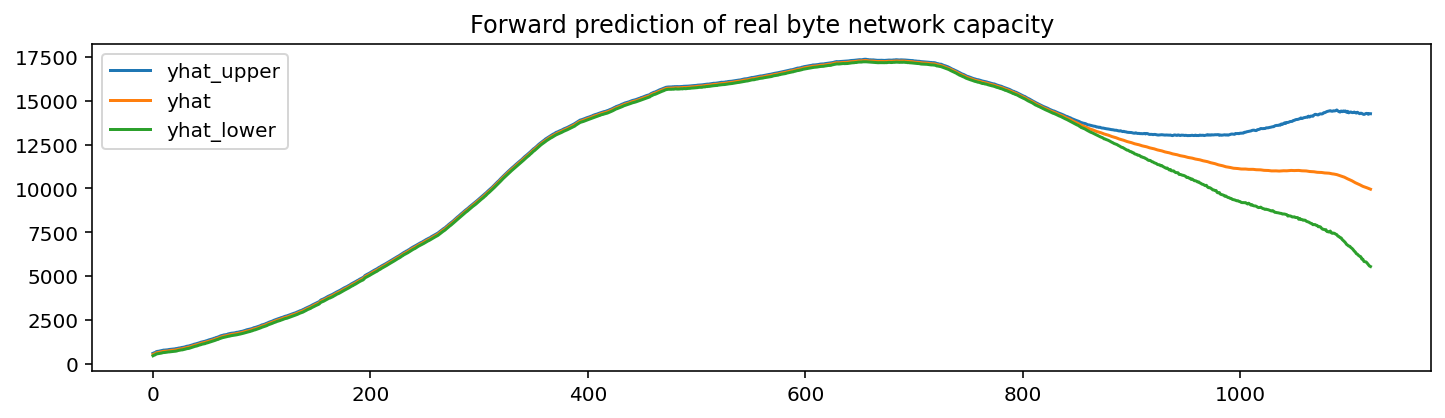

In [81]:
# Run separate predictions on RB and QA network power (daily frequency)
fcst = predict_on_dataframe(dfc, 'raw_bytes_network_power')
fcst_qa = predict_on_dataframe(dfc, 'qa_bytes_network_power')

fig, ax = plt.subplots(figsize=(12,3))
fcst[['yhat_upper', 'yhat', 'yhat_lower']].plot(ax=ax)
ax.set_title('Forward prediction of real byte network capacity')

In [82]:
df_new = interpolate_predictions(df, fcst, 'raw_bytes_network_power')
df_new_qa = interpolate_predictions(df, fcst_qa, 'qa_bytes_network_power')

Now let's check that the calculations are working as expected and that the interpolations make sense:
* There should be a second baseline crossing around Feb-Apr 2023
* The calculated and original network heights should overlap as perfectly as possible

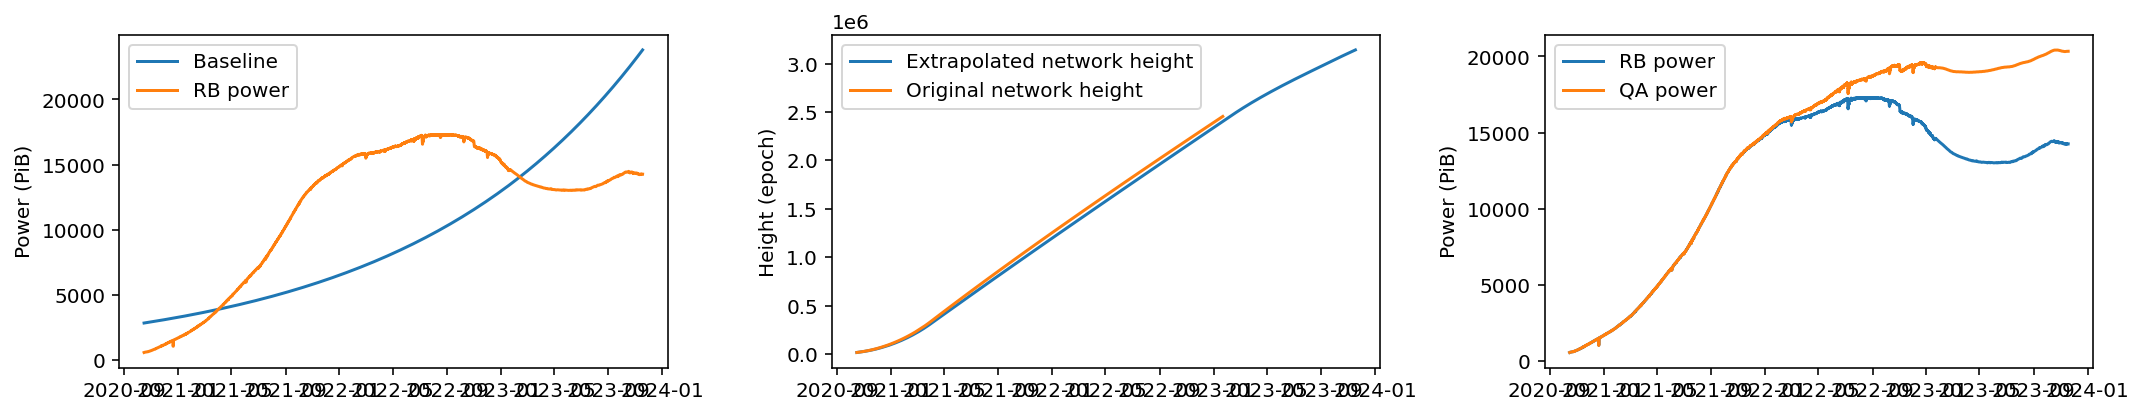

In [83]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(15,3))
ax1.plot(df_new['datetime'], df_new['baseline_power'], label='Baseline')
ax1.plot(df_new['datetime'], df_new['raw_bytes_network_power'], label='RB power')
ax1.legend(loc='upper left')
ax2.plot(df_new['datetime'], df_new['est_network_height'], label="Extrapolated network height")
ax2.plot(df['datetime'], df['network_height'], label='Original network height')
ax2.legend(loc='upper left')
ax3.plot(df_new['datetime'], df_new['raw_bytes_network_power'], label='RB power')
ax3.plot(df_new_qa['datetime'], df_new_qa['qa_bytes_network_power'], label='QA power')
ax3.legend(loc='upper left')
ax1.set_ylabel('Power (PiB)')
ax2.set_ylabel('Height (epoch)')
ax3.set_ylabel('Power (PiB)')
plt.tight_layout()

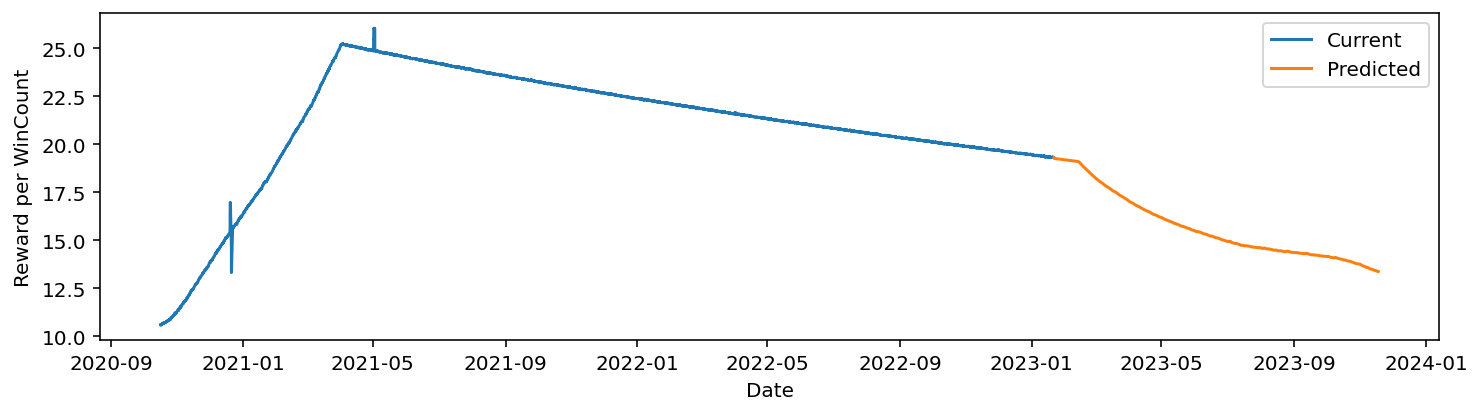

In [72]:
df_new = interpolate_predictions(df, fcst, 'raw_bytes_network_power')
df_out = calculate_block_reward(df_new)

fig, ax = plt.subplots(figsize=(12,3))
ax.plot(df_out['datetime'].iloc[0:len(df)], 1.4*df_out['w'].iloc[0:len(df)], label='Current')
ax.plot(df_out['datetime'].iloc[len(df):], 1.4*df_out['w'].iloc[len(df):], label='Predicted', color='C1')
ax.set_ylabel('Reward per WinCount')
ax.set_xlabel('Date')
ax.legend(loc='upper right')

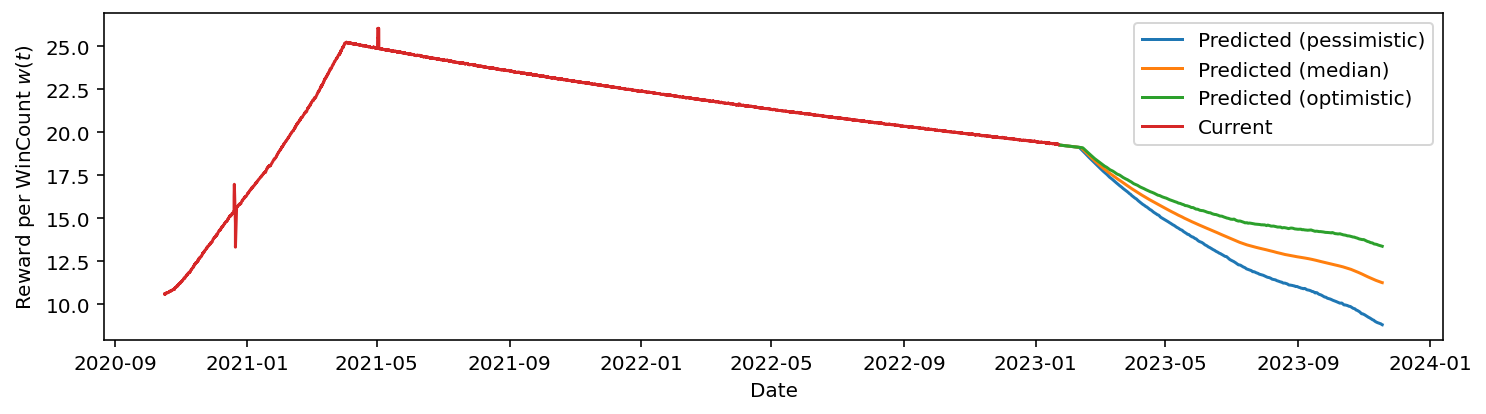

In [74]:
fig, ax = plt.subplots(figsize=(12,3))

for yh,lbl in zip(['yhat_lower', 'yhat', 'yhat_upper'], ['pessimistic', 'median', 'optimistic']):

    df_new = interpolate_predictions(df, fcst, 'raw_bytes_network_power', yh)
    df_out = calculate_block_reward(df_new)
    ax.plot(df_out['datetime'].iloc[len(df):], 1.4*df_out['w'].iloc[len(df):], label='Predicted (%s)'%lbl)

ax.plot(df_out['datetime'].iloc[0:len(df)], 1.4*df_out['w'].iloc[0:len(df)], label='Current')
ax.set_ylabel('Reward per WinCount $w(t)$')
ax.set_xlabel('Date')
ax.legend(loc='upper right')

### Calculate initial pledge

In [86]:
sector_size_pib = 32*1e9/2**50

df['storage_pledge'] = sector_size_pib * ratio_extract(
    df['new_reward_smoothed_position_estimate'], 
    df['new_reward_smoothed_velocity_estimate'],
    df['qa_smoothed_position_estimate'],
    df['qa_smoothed_velocity_estimate'],
    20 * 1440 * 2)

df['consensus_pledge'] = 0.3 * df['circulating_fil'] * sector_size_pib / df[['new_baseline_power', 'qa_bytes_network_power']].max(axis=1)
df['initial_pledge'] = df['storage_pledge'] + df['consensus_pledge']

# Usually the most recent day has incomplete wincount, so impute this with the mean of previous 10 days
df.iloc[-1, df.columns.get_loc('win_count')] = df.iloc[-10:-1]['win_count'].mean()

/Users/beng/miniforge3/envs/tf/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Text(0.5, 1.0, 'Initial pledge per 32 GiB QAP')

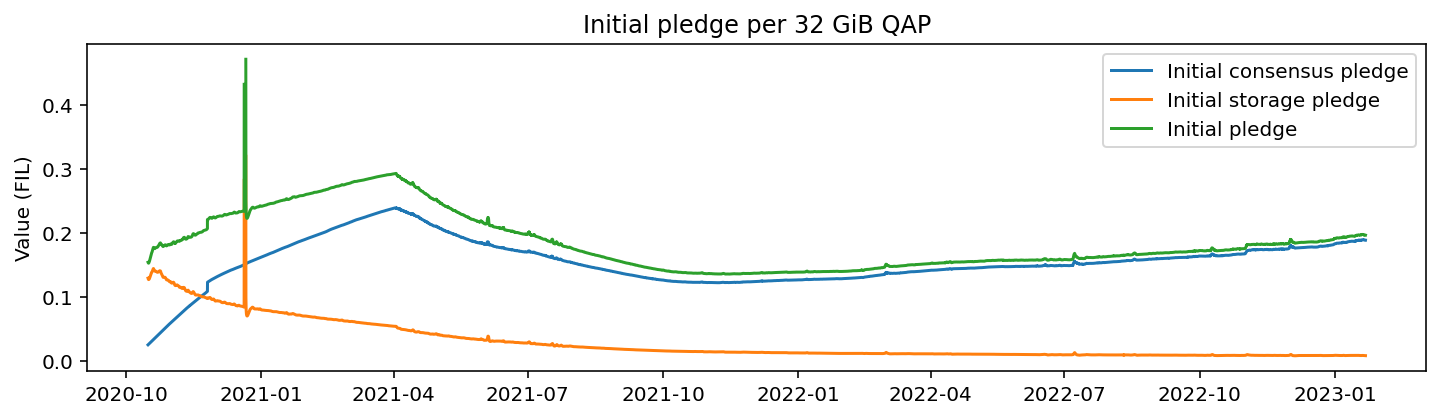

In [98]:
fig, ax = plt.subplots(figsize=(12,3))
ax.plot(df.datetime, df['consensus_pledge'], label='Initial consensus pledge')
ax.plot(df.datetime, df['storage_pledge'], label='Initial storage pledge')
ax.plot(df.datetime, df['initial_pledge'], label='Initial pledge')
ax.legend(loc='upper right')
ax.set_ylabel('Value (FIL)')
ax.set_title('Initial pledge per 32 GiB QAP')

The initial pledge matches rather well with the Starboard dashboard.

### Completed

* Forward predictions of QA and RB capacities
* Initial sector pledge

### Still left to do

* Balance sheet
    * Assume that one collects miner rewards every day for 300 days
    * Calculate the cumulative rewards collected
    * Calculate the cumulative pledges paid
